In [1]:
from PIL import Image
from PIL import ImageOps
import numpy as np
from pathlib import Path
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import random
from IPython import display

plt.style.use('dark_background')

root = Path(".")

In [2]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(1, 8, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv1d(8, 16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv1d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2))
        self.output = nn.Sequential(
            nn.Linear(2048, 2))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = self.output(out)
        return out

In [3]:
class predictdataset:
    def __init__(self, directory):
        self.directory = directory
        self.index = str(directory)[-3:]
        self.filepaths = [directory / file for file in os.listdir(directory) if ".tif" in file][:512]
        self.imagetensors = {file: transforms.ToTensor()(ImageOps.autocontrast(Image.open(file).convert('L').resize((256, 256)))).cuda().squeeze() \
                             for file in self.filepaths}
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    def tensor(self, coordinates):
        data = torch.zeros((1, 1, 512), device=self.device)
        for t, file in enumerate(self.filepaths):
            data[0, 0, t] = self.imagetensors[file][coordinates]
        data[0,0,:] = data[0,0,:]/torch.max(data).item()
        data.requires_grad_(True)
        return data

class realdataset:
    def __init__(self, directory):
        self.directory = directory
        self.index = str(directory)[-3:]
        self.filepaths = [directory / file for file in os.listdir(directory) if ".tif" in file][:512]
        self.imagetensors = {file: transforms.ToTensor()(ImageOps.autocontrast(Image.open(file).convert('L').resize((256,256)))).cuda().squeeze() \
                             for file in self.filepaths}
        self.ground_truth = np.loadtxt(directory / ".." / ".." / "output" / self.index / "indices.txt", dtype=float)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    def positives(self):
        return list(zip(np.where(self.ground_truth!=0)[0], np.where(self.ground_truth!=0)[1]))
    def controls(self):
        total = np.shape(self.ground_truth)[0]*np.shape(self.ground_truth)[1]
        negative_count = np.shape(self.ground_truth[np.where(self.ground_truth==0)])[0]
        positive_count = total-negative_count
        negatives = list(zip(np.where(self.ground_truth==0)[0], np.where(self.ground_truth==0)[1]))
        picked_negatives = random.sample(negatives, positive_count)
        return picked_negatives
    def tensor(self, p, coordinates):
        labels = torch.zeros(1, dtype=torch.int64, device=self.device)
        labels[0] = 1 if p==1 else 0
        data = torch.zeros((1, 1, 512), device=self.device)
        for t, file in enumerate(self.filepaths):
            data[0, 0, t] = self.imagetensors[file][coordinates]
        data[0,0,:] = data[0,0,:]/torch.max(data).item()
        data.requires_grad_(True)
        return labels, data
    
class synthdataset:
    def __init__(self, directory):
        self.directory = directory
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.positives = [directory / "positives" / file for file in os.listdir(directory / "positives")]
        self.negatives = [directory / "negatives" / file for file in os.listdir(directory / "negatives")]
        self.all = list(zip([1 for _ in self.positives]+[0 for _ in self.negatives], self.positives+self.negatives))
        self.time = 512
        self.allshuffle = random.sample(self.all, len(self.all))
    def load(self, file):
        return np.loadtxt(file, dtype=float)
    def tensor(self, p, file):
        label = torch.zeros(1, dtype=torch.int64, device=self.device)
        label[0] = 1 if p==1 else 0
        data = torch.zeros(self.time, device=self.device)
        npdata = self.load(file)
        for t in range(self.time):
            data[t] = npdata[t]
        data.requires_grad_(True)
        return label, data
    def create_batch(self, batch_size):
        assert len(self.allshuffle)%batch_size==0
        n_used = 0
        def gen_batch():
            nonlocal n_used
            if n_used == len(self.allshuffle):
                return None
            else:
                labels = torch.stack([self.tensor(p, coordinate)[0] for p,coordinate in self.allshuffle[n_used:n_used+batch_size]])
                inputs = torch.stack([self.tensor(p, coordinate)[1] for p,coordinate in self.allshuffle[n_used:n_used+batch_size]])
                inputs = inputs[:, None, :]
                n_used += batch_size
                return labels, inputs
        return gen_batch
    
def batch_accuracy(outputs, labels):
    probabilities = torch.nn.Softmax(1)(outputs)
    scores = []
    for i, index in enumerate(labels):
        scores += [probabilities[i, index.item()].item()]
    return np.mean(scores)

def accuracy(outputs, labels):
    probabilities = torch.nn.Softmax(1)(outputs)
    return probabilities[0, labels.item()].item()

In [ ]:
data = sdataset(root / "output" / "training_data")

In [ ]:
net = ConvNet()
net.cuda()
criterion = nn.CrossEntropyLoss(reduction='mean')
optimizer = optim.Adam(net.parameters(), lr=.01)

In [ ]:
fig, ax = plt.subplots(1,1)
ax2 = ax.twinx()
loss_ax = []
accuracy_ax = []
for epoch in range(10):
    batch_generator = data.create_batch(100)
    batch = batch_generator()
    i=0
    while batch is not None:
        optimizer.zero_grad()
        
        labels, inputs = batch[0].squeeze(), batch[1]
        labels, inputs = labels.cuda(), inputs.cuda()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        loss_ax += [loss.item()]
        accuracy_ax += [batch_accuracy(outputs, labels)]
        
        ax.cla()
        ax2.cla()
        ax.plot(loss_ax)
        ax.set_title("epoch %d, iter %d"%(epoch, i))
        ax.set_xlabel("Iteration number")
        ax.set_ylabel("CrossEntropyLoss")
        ax2.plot(accuracy_ax, color='red')
        ax2.set_ylabel("Probability of correct answer", color='red')
        display.clear_output(wait=True)
        display.display(plt.gcf())
        
        batch = batch_generator()
        i += 1

In [ ]:
torch.save(net.state_dict(), "new")

In [ ]:
data = sdataset(root / "output" / "validation_data")

In [ ]:
device = torch.device("cuda")
net = ConvNet()
net.load_state_dict(torch.load(root / "saved_models" / "2020_09_07_3epochs" / "model"))
net.to(device)

In [ ]:
fig, ax = plt.subplots(1,1)
accuracy_ax = []
batch_generator = data.create_batch(1)
batch = batch_generator()
i=0
while batch is not None:
    labels, inputs = batch[0].squeeze(), batch[1]
    labels, inputs = labels.cuda(), inputs.cuda()
    outputs = net(inputs)

    accuracy_ax += [accuracy(outputs, labels)]
    ax.cla()
    ax.plot(accuracy_ax, color='red')
    ax.set_xlabel("Iteration number")
    ax.set_ylabel("Probability of correct answer")
    display.clear_output(wait=True)
    display.display(plt.gcf())
    batch = batch_generator()
    i += 1

In [4]:
data = predictdataset(root / "data" / "002")

In [5]:
device = torch.device("cuda")
net = ConvNet()
net.load_state_dict(torch.load(root / "saved_models" / "2020_09_07_3epochs" / "model"))
net.to(device)

ConvNet(
  (layer1): Sequential(
    (0): Conv1d(1, 8, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv1d(8, 16, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv1d(16, 32, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (output): Sequential(
    (0): Linear(in_features=2048, out_features=2, bias=True)
  )
)

In [8]:
accuracy_ax = []
n=256

mask = np.zeros((n, n))
for row in range(n):
    for col in range(n):
        inputs = data.tensor((row, col))
        inputs = inputs.cuda()
        outputs = net(inputs)

        probabilities = torch.nn.Softmax(1)(outputs)
        result = torch.topk(probabilities, 1).indices
        if result == 1:
            mask[row, col] = 1
        print("%03d, %03d"%(row, col), end='\r')
    if row==5:
        break

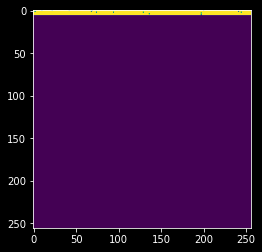

In [9]:
plt.imshow(mask)